In [2]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

In [46]:
from plotnine import ggplot, geom_point, aes, geom_line, labs, geom_text, position_jitter, theme, element_text, theme_linedraw, element_line, element_rect, scale_y_continuous, scale_x_continuous
import matplotlib.pyplot as plt

In [3]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

In [4]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = 'view 3 (eq up)');

In [5]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = False)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)

In [7]:
scenarios *= 12 # annualize

In [16]:
total = 1000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio1_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio1_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

In [24]:
manual_constraints[0]

,EUR Government Bonds,EUR 5v5 SWAP,EUR Investment Grade Corporate Bonds
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,1


The optimization was succesful: True
EUR Government Bonds: 500000.0
EUR 5v5 SWAP: 100000.0
EUR Investment Grade Corporate Bonds: 500000.0


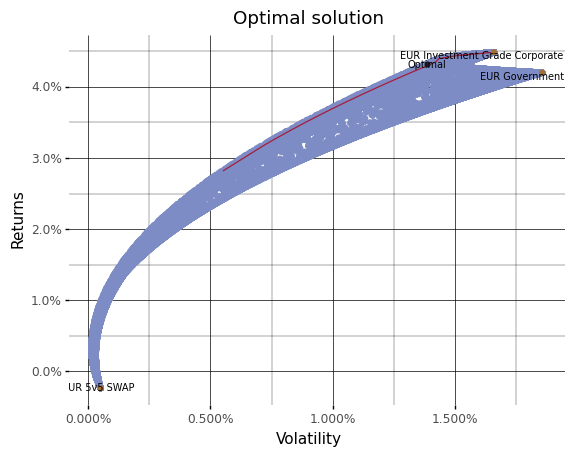

In [80]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         posterior,
                                         mu_0 = 5,
                                         total = total,
                                         manual_constraints = manual_constraints,
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [81]:
np.sqrt(optimal_x.T @ np.cov(asset_scenarios.T) @ optimal_x) / total

0.11910151738157883

In [82]:
optimal_x = np.array([500000, 100000, 500000])
retscen = (asset_scenarios @ optimal_x) / total # return scenarios
mu_opt, vol_opt = retscen.dot(posterior), np.sqrt(np.cov(retscen, aweights=posterior)) # weighted avg and std
mu_opt * 100, vol_opt * 100 # the mean and variance of the optimal portfolio in percent

(4.321733868587559, 11.774284041957495)

In [125]:
# ggplot
vol = asset_scenarios.apply(lambda x: np.sqrt(np.cov(x, aweights=posterior))) * 100
mu  = asset_scenarios.T @ posterior * 100
# extra_mu = asset_scenarios.iloc[:,13:15].T @ posterior * 100

generated_points = 10000
port_returns = np.array([])
port_vol = np.array([])
for i in range(0, generated_points):
    # sample such positions that satisfy constrs
    # pos1 = (np.random.rand()**5)*500000 + 500000 # asset i position in [500000, 1000000]
    pos1 = 500000 + (i/generated_points)*500000
    pos3 = 1000000 - pos1 # sum is equal to 1000000
    pos2 = np.random.rand()*100000 # swap
    y = np.array([pos1, pos2, pos3])
    port_returns = np.append(port_returns, mu @ y / total)
    port_vol     = np.append(port_vol,     np.sqrt(np.cov(np.dot(asset_scenarios, y) * 100 / total, aweights = posterior)))

generated_df = pd.DataFrame(list(zip(port_vol, port_returns)), columns = ["Volatility", "Returns"])

In [154]:
# create a line to indicate the volas and returns of convex combinations of assets 1 and 3 only
conv_returns = np.array([])
conv_vol = np.array([])
for i in range(1000):
    pos1 = (i/1000)*total
    pos3 = total - pos1
    y = np.array([pos1, 0, pos3])
    conv_returns = np.append(conv_returns, mu @ y / total)
    conv_vol     = np.append(conv_vol,     np.sqrt(np.cov(np.dot(asset_scenarios, y) * 100 / total, aweights = posterior)))

conv_df = pd.DataFrame(list(zip(conv_vol, conv_returns)), columns = ['Volatility', 'Returns'])

In [190]:
plot = (ggplot()
        + theme(legend_title = element_text(
                family = "Calibri",
                colour = "brown",
                face = "bold",
                size = 12))
        + theme(panel_grid_major = element_line(size = 0.5,
                                                linetype = 'solid',
                                                colour = "black"),
                panel_grid_minor = element_line(size = 0.25,
                                                linetype = 'solid',
                                                colour = "black"),
                panel_background = element_rect(fill = "white"))
        + labs(title="Optimal solution", y="Returns", x="Volatility")
#        + scale_y_continuous(labels=lambda l: ["%.1f%%" % (v * 100) for v in l])
#        + scale_x_continuous(labels=lambda l: ["%.3f%%" % (v * 100) for v in l])
        + geom_point(data = generated_df,
                     mapping = aes(x = "Volatility",
                        y = "Returns"),
                     color = "#7D8CC4"
                    )
        + geom_point(data = conv_df,
                    mapping= aes(x = "Volatility",
                        y = "Returns"),
                    color = "#A61C3C",
                    size = 0.1
                    )
        + geom_point(mapping = aes(x = vol_opt * 100, y=mu_opt * 100),
                     color = "#FF0000",
                     #shape=13
                     )
        + geom_text(mapping = aes(x = vol_opt * 100, y=mu_opt * 100),
                     label = "Optimal",
                     nudge_y = -0.01,
                     #nudge_x = 0.5,
                     size = 7,
                     )
        + geom_point(aes(x = vol[[0, 2]], y = mu[[0, 2]]),
                     color = "#A27035"
                     )
        + geom_text(aes(x = vol[[0, 2]], y = mu[[0, 2]]),
                     label = asset_scenarios.columns[[0, 2]],
                     nudge_y = -0.01,
                     nudge_x = [-0.3, 0],
                     size = 7,
                     # position=position_jitter()
                     )

    )# .draw()

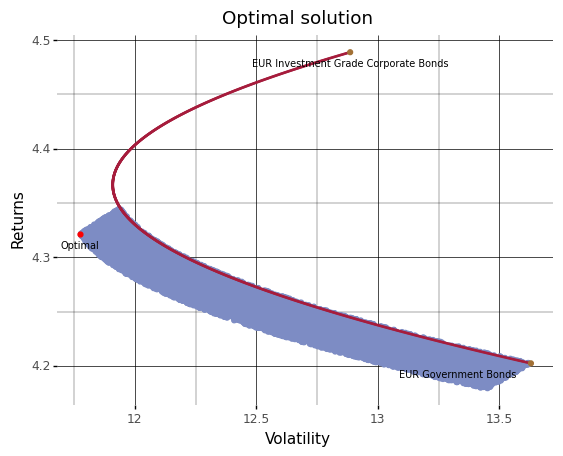

<ggplot: (321669871)>

In [191]:
plot

In [192]:
plot.save('portfolio1_plot.eps')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: portfolio1_plot.eps


In [111]:
mu

EUR Government Bonds                    4.202349
EUR 5v5 SWAP                           -0.238528
EUR Investment Grade Corporate Bonds    4.488824
dtype: float64

In [116]:
vol

EUR Government Bonds                    13.629869
EUR 5v5 SWAP                             2.254353
EUR Investment Grade Corporate Bonds    12.886003
dtype: float64

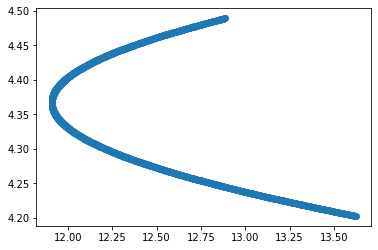

In [157]:
plt.scatter(x = conv_df.Volatility, y = conv_df.Returns)

In [153]:
conv_df.shape

(10001, 2)

In [150]:
del conv_df